In [34]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as torch_data
import torch.nn.functional as F

from PIL import Image
import tqdm

In [35]:
import glob

all_data = glob.glob('/kaggle/input/echo-all/Extracted/*.jpg')
data = [path for path in all_data if '_mask' not in path]

dataframe = pd.DataFrame(data, columns=['paths'])

In [36]:
class CustomDataset(Dataset):
    
    def __init__(self, dataframe: list, lr_transforms, hr_transforms):
        self.data = dataframe
        self.lr_transforms = lr_transforms
        self.hr_transforms = hr_transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['paths']

        hr_images = Image.open(image_path).convert('RGB') 

        lr_image = self.lr_transforms(hr_images)
        hr_image = self.hr_transforms(hr_images)

        return lr_image, hr_image

In [37]:
class InterpolateTransform:
    def __init__(self, size, mode='bicubic'):
        self.size = size
        self.mode = mode
    
    def __call__(self, tensor):
        return F.interpolate(tensor.unsqueeze(0), size=self.size, mode=self.mode, align_corners=False).squeeze(0)

In [38]:
image_size = 256
   
    
hr_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


lr_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
    InterpolateTransform(size=(image_size // 4, image_size // 4)),
])

train_dataset = CustomDataset(dataframe, lr_transforms, hr_transforms)

batch_size = 1
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [39]:
for batch in dataloader:
    inputs = batch
    print("Input shape:", inputs[0].shape)
    break

Input shape: torch.Size([1, 3, 64, 64])


LR shape:  torch.Size([3, 64, 64])


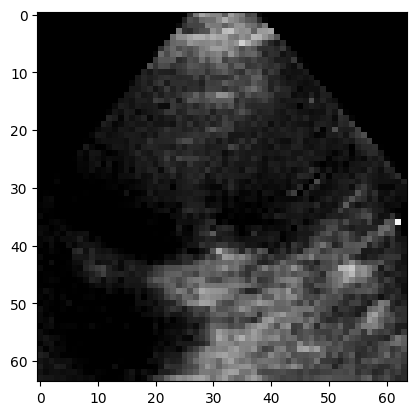

HR shape:  torch.Size([3, 256, 256])


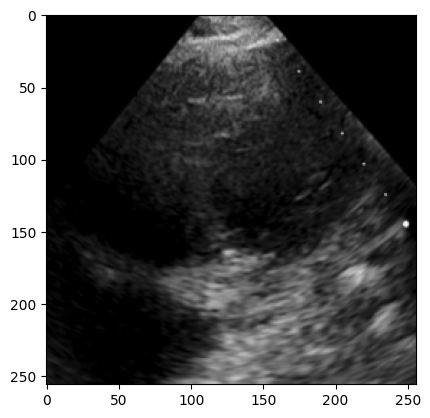

In [40]:
print('LR shape: ', inputs[0][0].shape)
plt.imshow(inputs[0][0].permute(1,2,0).numpy())
plt.show()
print('HR shape: ', inputs[1][0].shape)
plt.imshow(inputs[1][0].permute(1,2,0).numpy())
plt.show()

In [94]:
class RWMAB(nn.Module):
    """
    This class implements the Residual Whole Map Attention Network (RWMAN),
    a modification of RCAN for extracting features from low-resolution (LR) images
    and feeding them into a generator for image upscaling.
    """

    def __init__(self, input_shape: int = 64) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        )
        self.attention = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_out = self.conv1(x)
        attention = self.attention(x_out)
        x_out = torch.mul(x_out, attention) + x
        return x_out

class ShortResidualConnection(nn.Module):
    def __init__(self, input_shape: int = 64) -> None:
        super().__init__()
        RWMAN = []
        for _ in range(16):
            RWMAN.append(RWMAB())
        
        self.src = nn.Sequential(*RWMAN, 
                            nn.Conv2d(64, 64, kernel_size=1, stride=1))

    def forward(self, x):
        x_1 = self.src(x)
        return x_1 + x


class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
    
        self.conv_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.lrc = []
        for _ in range(8):
            self.lrc.append(ShortResidualConnection())
        self.conv_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.lrc = nn.Sequential(*self.lrc, self.conv_2)
        
        upsample_1 = nn.Sequential(nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                                  nn.PixelShuffle(2),
                                  nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                                  nn.PixelShuffle(2))
        conv_3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
                            
        self.upscaler = nn.Sequential(upsample_1, conv_3)
                            
    def forward(self, x):
        x_1 = self.conv_1(x)   
        x_2 = self.lrc(x_1)
        x_out = x_1 + x_2
        return self.upscaler(x_out)

In [95]:
class DBlock(nn.Module):
    
    def __init__(self, input_shape: int = 64,
                 output_shape: int = 64,
                 stride: int = 2,
                 bn: bool = True,
                 padding: int = 1) -> None:
        super().__init__()
        self.bntrue = bn
        self.conv_1 = nn.Conv2d(input_shape, output_shape, kernel_size=3, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(num_features=output_shape)
        self.leakyr = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        if self.bn == True:
            return self.leakyr(self.bn(self.conv_1(x)))
        else:
            return self.leakyr(self.conv_1(x))

class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block_1_sr = nn.Sequential(DBlock(3, 64, stride=1, bn=False),
                                DBlock(64, 64, stride=2))
        self.block_2_sr = nn.Sequential(DBlock(64, 128, stride=1),
                                DBlock(128, 128, stride=2))
        self.block_1_lr = nn.Sequential(DBlock(3, 64, stride=1, bn=False),
                                DBlock(64, 128, stride=1, bn=True))
        
        self.block_1 = nn.Sequential(DBlock(128, 256, stride=1),
                                DBlock(256, 256, stride=2))
        self.block_2 = nn.Sequential(DBlock(256, 512, stride=1),
                                DBlock(512, 512, stride=2))
        self.block_3 = nn.Sequential(DBlock(512, 1024, stride=1),
                                DBlock(1024, 1024, stride=2))
        
        self.final = nn.Sequential(nn.Linear(1024*8*8,100),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(100, 1),
                                  nn.Sigmoid())
        
    def forward(self, y, x):
        x_1 = self.block_1_sr(x)
        x_2 = self.block_2_sr(x_1)
        y_1 = self.block_1_lr(y)
        xy = torch.add(x_2, y_1)
        xy_1 = self.block_1(xy)
        xy_2 = self.block_2(xy_1)
        xy_3 = self.block_3(xy_2)
        xy_3 = xy_3.view(xy_3.size(0), -1)
        final = self.final(xy_3)
        
        return (x_1, x_2, xy_1, xy_2, xy_3, final)

In [130]:
class GeneratorLossFunction(nn.Module):
    def __init__(self, device: str = 'cuda', lambda1: float = 1e-2, lambda2: float = 1e-4,
                 vgg_layers: list[int] = [2, 7, 16, 25, 34],
                 weights: list[float] = [1/2, 1/4, 1/8, 1/64, 1/128]) -> None:
        
        super().__init__()
        
        self.vgg = models.vgg19(pretrained=True).features.to(device).eval()
        
        self.layers = vgg_layers
        self.weights = weights
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()
        self.lambda1 = lambda1
        self.lambda2 = lambda2

            
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, discriminator, LR, HR, SR):
        return self.content_loss(HR, SR) + self.lambda1 * self.adversarial_loss(discriminator, LR, HR, SR) + self.lambda2 * self.adversarial_feature_loss(discriminator, LR, HR, SR)

    def vgg_extract(self, x):
        layers_output = []
        for layer in self.vgg:
            x = layer(x)
            layers_output.append(x)

        features = [layers_output[layer] for layer in self.layers]
        return features
    
    def content_loss(self, HR, SR, lambda_l1=0):
        HR_features = self.vgg_extract(HR)
        SR_features = self.vgg_extract(SR)
        
        loss = 0.0
        for i in range(len(self.layers)):
            loss += self.weights[i] * self.mse_loss(SR_features[i], HR_features[i])
        
        l1_loss = self.l1_loss(HR, SR)
        content_loss = lambda_l1 * l1_loss + loss
        
        return content_loss
        
        
    def adversarial_loss(self, discriminator, lr, hr, sr):
        """
        Compute the adversarial loss for the generator.
        """
        d_real = discriminator(lr, hr)[-1]
        d_fake = discriminator(lr, sr)[-1]
        adv = -torch.log(1 - d_real) - torch.log(d_fake)
        return adv.mean()
        
    def adversarial_feature_loss(self, discriminator, lr, hr, sr):
        """
        Compute the adversarial feature loss for the generator.
        """

        weights = [1/2, 1/4, 1/8, 1/64, 1/128]

        d_real = discriminator(lr, hr)
        d_fake = discriminator(lr, sr)

        advfeat = 0
        for idx in range(len(weights)):
            advfeat += weights[idx] *  nn.MSELoss()(d_real[idx], d_fake[idx])

        return advfeat.mean()

In [131]:
class DiscriminatorLossFunction(nn.Module):
    def __init__(self, device: str = 'cuda'):
        super().__init__()
        
    def forward(lr, hr, sr):
        loss = -1*torch.log(hr) - torch.log(1-sr)
        return loss

In [138]:
a = torch.randn(8, 3, 128, 128)

In [152]:
a.mean(dim=(1,2,3))


tensor([-1.0480e-05,  6.1430e-03,  4.6565e-03, -1.6802e-03,  1.5729e-04,
         6.9321e-03, -4.9289e-03, -4.0475e-03])

In [153]:
class Trainer(nn.Module):
    
    def __init__(self, generator: nn.Module = None, discriminator: nn.Module = None,
                 g_loss: nn.Module = None, d_loss: nn.Module = None,
                 batch_size: int = 4, dataloader: DataLoader = None,
                 mean: tuple[float, float, float] = (0.5, 0.5, 0.5),
                 std: tuple[float, float, float] = (0.5, 0.5, 0.5),
                 device: str = 'cuda') -> None:
        super().__init__()
        
        self.generator = generator
        self.discriminator = discriminator
        self.dataloader = dataloader
        self.mean = mean
        self.fixed_latent = torch.randn(batch_size, 512, 14, 14)
        self.g_loss = g_loss
        self.d_loss = d_loss
        self.device = device
        
    def denorm(self, img_tensor: torch.Tensor) -> torch.Tensor:
        return img_tensor * self.mean[0] + self.std[0]
    
    def save_samples(self, index: int = 0) -> None:
            
        latent_tensors = torch.randn(64, self.latent_size, 1, 1, device=self.device)
        fake_images = self.generator(latent_tensors)
        fake_fname = f'generated-images-{index:04d}.png'
        save_image(fake_images, os.path.join(fake_fname), nrow=8)
        print('Saving', fake_fname)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(self.denorm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))
        plt.show()
        
    def train_discriminator(self, lr_image, hr_image, opt_d):
        opt_d.zero_grad()

        hr_preds = self.discriminator(lr_image, hr_image)[-1]
        hr_targets = torch.ones(lr_image.size(0), 1, device=self.device)
        real_loss = F.binary_cross_entropy(hr_preds, hr_targets)
        real_score = hr_preds.mean(dim=(1,2,3))
        
        sr_image = self.generator(lr_image)
        sr_targets = torch.zeros(lr_image.size(0), 1, device=self.device)
        sr_preds = self.discriminator(lr_image, sr_image)[-1]
        fake_loss = F.binary_cross_entropy(sr_preds, sr_targets)
        fake_score = sr_preds.mean(dim=(1,2,3))

        loss = real_loss + fake_loss
        loss.backward()
        opt_d.step()

        return loss.item(), real_score, fake_score

    def train_generator(self, lr_image, hr_image, opt_g):
        opt_g.zero_grad()
        
        sr_image = self.generator(lr_image)

        preds = self.discriminator(lr_image, sr_image)[-1]
        targets = torch.ones(lr_image.size(0), 1, device=self.device)
        loss = self.g_loss(self.discriminator, lr_image, hr_image, sr_image)

        loss.backward()
        opt_g.step()

        return loss.item()
    
    
    def fit(self, epochs: int = 1, learning_rate: float = 1e-4, beta: tuple[float, float] = (0.9, 0.999), start_idx=1):
        torch.cuda.empty_cache()

        losses_g = []
        losses_d = []
        real_scores = []
        fake_scores = []

        opt_d = optim.Adam(self.discriminator.parameters(), lr=learning_rate, betas=beta)
        opt_g = optim.Adam(self.generator.parameters(), lr=learning_rate, betas=beta)

        for epoch in range(epochs):
            for real_images in tqdm.tqdm(self.dataloader):
                lr_image, hr_image = real_images[0].to(self.device), real_images[1].to(self.device)
                loss_d, real_score, fake_score = self.train_discriminator(lr_image, hr_image, opt_d)
                loss_g = self.train_generator(lr_image, hr_image, opt_g)

            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))
            
            if epoch % 10 == 0:
                # Save generated images
                self.save_samples(epoch + start_idx)

        return losses_g, losses_d, real_scores, fake_scores

In [154]:
generator = Generator().to('cuda')
discriminator = Discriminator().to('cuda')

gen_loss = GeneratorLossFunction()
dis_loss = DiscriminatorLossFunction()


trainer = Trainer(generator, discriminator, gen_loss, dis_loss, dataloader=dataloader)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
losses_g, losses_d, real_scores, fake_scores = trainer.fit()

In [157]:
import gc
torch.cuda.empty_cache()
gc.collect()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
